In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [2]:
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)



2 3
Balancing due to disguised labels.
This functions barely works, and is a piece of shit that should not be trusted. Only works because noise has id: 0
{'noise': 84799, 'earthquake': 84799, 'explosion': 82246}
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded noise non-noise dataset.
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (10631, 0.2526)  |  explosion: (10106, 0.2402)  |  noise: (21343, 0.5072)  
Val ds:
earthquake: (242, 0.0371)  |  explosion: (3125, 0.4788)  |  noise: (3160, 0.4841)  
Test ds:
earthquake: (184, 0.0423)  |  explosion: (2062, 0.4739)  |  noise: (2105, 0.4838)  


In [3]:
model_type = "CNN_grow_double"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "normalize"
use_noise_augmentor = True
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()

Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 236.67984461784363 seconds. Total datapoints fitted: 42080.
Average time per datapoint: 0.005624521022287159


Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 58.02566909790039 seconds. Total datapoints fitted: 6527.
Average time per datapoint: 0.0088900979160258


Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 37.53858757019043 seconds. Total datapoints fitted: 4351.
Average time per datapoint: 0.008627577009926552


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Stage one loading validation set, timeAug: [--------------------------------------->] 100 %

Stage one loading test set, timeAug: [--------------------------------------->] 100 %

Fit process of normalizer skipped as unecessary


Stage two loading traini

['20210502-132117']
Trying to create result file
Made result file:  results_CNN_grow_double_noiseNotNoise_timeAug_normalize_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3.csv
[   {'model_type': 'CNN_grow_double'},
    {   'batch_size': 256,
        'cnn_activation': 'relu',
        'dense_activation': 'relu',
        'dropout_T_bn_F': False,
        'dropout_rate': 0.01,
        'epochs': 150,
        'filter_size': 56,
        'first_dense_units': 252,
        'growth_sequence': [1, 2, 4],
        'l1_r': 0.0001,
        'l2_r': 0.01,
        'learning_rate': 0.0001,
        'num_filters': 72,
        'num_layers': 3,
        'optimizer': 'adam',
        'output_layer_activation': 'sigmoid',
        'padding': 'same',
        'second_dense_units': 214,
        'use_layerwise_dropout_batchnorm': False}]
Saving file. 2 rows.
results_CNN_grow_double_noiseNotNoise_timeAug_normalize_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3.csv saved to path:   /media

- val_f1: 0.9739
Epoch 19/150
164/164 [==============================] - 95s 578ms/step - loss: 0.1302 - binary_accuracy: 0.9638 - precision: 0.9771 - recall: 0.9481 - val_loss: 0.1031 - val_binary_accuracy: 0.9723 - val_precision: 0.9774 - val_recall: 0.9688
- val_f1: 0.9732
Epoch 20/150
164/164 [==============================] - 95s 581ms/step - loss: 0.1342 - binary_accuracy: 0.9612 - precision: 0.9734 - recall: 0.9471 - val_loss: 0.1028 - val_binary_accuracy: 0.9731 - val_precision: 0.9784 - val_recall: 0.9694
- val_f1: 0.9743
Epoch 21/150
164/164 [==============================] - 96s 583ms/step - loss: 0.1284 - binary_accuracy: 0.9626 - precision: 0.9749 - recall: 0.9479 - val_loss: 0.1065 - val_binary_accuracy: 0.9727 - val_precision: 0.9751 - val_recall: 0.9719
- val_f1: 0.9737
Epoch 22/150
164/164 [==============================] - 95s 577ms/step - loss: 0.1264 - binary_accuracy: 0.9636 - precision: 0.9752 - recall: 0.9503 - val_loss: 0.1167 - val_binary_accuracy: 0.9717 - val

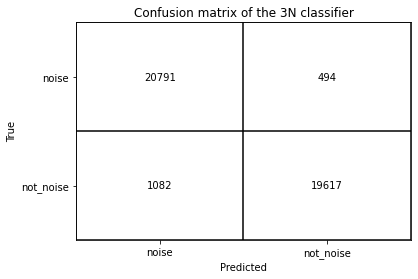

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[20791,   494],
       [ 1082, 19617]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.95      0.98      0.96     21285
   not_noise       0.98      0.95      0.96     20699

    accuracy                           0.96     41984
   macro avg       0.96      0.96      0.96     41984
weighted avg       0.96      0.96      0.96     41984

Unsaved val eval:
3015 85 84 3216
['noise', 'not_noise']
3N


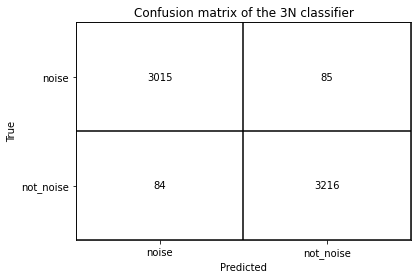

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3015,   85],
       [  84, 3216]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.97      0.97      0.97      3100
   not_noise       0.97      0.97      0.97      3300

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400

Unsaved test eval:
1910 61 50 2075
['noise', 'not_noise']
3N


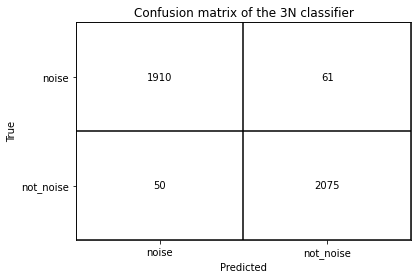

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1910,   61],
       [  50, 2075]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.97      0.97      0.97      1971
   not_noise       0.97      0.98      0.97      2125

    accuracy                           0.97      4096
   macro avg       0.97      0.97      0.97      4096
weighted avg       0.97      0.97      0.97      4096



In [4]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = False
use_reduced_lr = True
log_data = True

beta = 1

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModelRam(noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, 
                              start_from_scratch = start_from_scratch, beta = beta)
"""
# InceptionTime params
params = {    
    "batch_size" : 512,
    "epochs" : 50,
    "learning_rate" : 0.01,
    "optimizer" : "rmsprop",
    "use_residuals" : True,
    "use_bottleneck" : False,
    "num_modules" : 1,
    "filter_size" : 40,
    "bottleneck_size" : 26,
    "num_filters" : 32,
    "residual_activation" : "tanh",
    "module_activation" : "sigmoid",
    "module_output_activation" : "sigmoid",
    "output_layer_activation": "sigmoid",
    "reg_residual": True,
    "reg_module" : False,
    "l1_r" : 0,
    "l2_r" : 0.1
}
"""
### CNN grow double params
params = {    
    'batch_size': 256,
    'cnn_activation': 'relu',
    'dense_activation': 'relu',
    'dropout_T_bn_F': False,
    'dropout_rate': 0.01,
    'epochs': 150,
    'filter_size': 56,
    'first_dense_units': 252,
    'growth_sequence': [1, 2, 4, 8, 16],
    'l1_r': 0.0001,
    'l2_r': 0.01,
    'learning_rate': 0.0001,
    'num_filters': 72,
    'num_layers': 3,
    'optimizer': 'adam',
    'output_layer_activation': 'sigmoid',
    'padding': 'same',
    'second_dense_units': 214,
    'use_layerwise_dropout_batchnorm': False
}
model = modelTrain.run(x_train, y_train, x_val, y_val, x_test, y_test, 16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, **params)

3016 84 83 3217


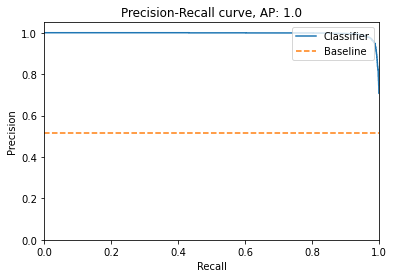

['noise', 'not_noise']
3N


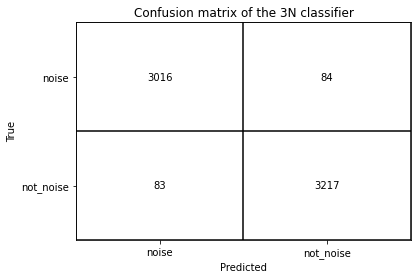

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3016,   84],
       [  83, 3217]], dtype=int32)>
              precision    recall  f1-score   support

       noise       0.97      0.97      0.97      3100
   not_noise       0.97      0.97      0.97      3300

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400



In [5]:
conf, report, accuracy, precision, recall, fscore = helper.evaluate_generator(model, x_val, y_val, params["batch_size"],
                                                                             loadData.label_dict, num_channels, noiseAug,
                                                                             scaler_name, 2, plot_conf_matrix = True, plot_p_r_curve = True, beta = beta)

In [6]:
accuracy, precision, recall, fscore

(0.97390624999999997, 0.974553, 0.97484800000000005, 0.97470100000000004)

In [7]:
save_dir = '/media/tord/T7/Thesis_ssd/SavedModels/CNN'
model_name = 'CNN_3E_final'
model_path = f'{save_dir}/{model_name}'

#model.save(model_path)
#model = tf.keras.models.load_model(model_path)

In [8]:
predictions = helper.predict_RamGenerator(model, x_val, y_val, params["batch_size"], True, noiseAug, loadData.label_dict, 3)
rounded_predictions = np.rint(predictions)

In [9]:
def get_false_negative_indexes(rounded_predictions, y_test):
    false_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 0:
            false_negative_indexes.append(i)
    return false_negative_indexes

def get_false_positive_indexes(rounded_predictions, y_test):
    false_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 1:
            false_positive_indexes.append(i)
    return false_positive_indexes

def get_true_positive_indexes(rouneded_predictions, y_test):
    true_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 1:
            true_positive_indexes.append(i)
    return true_positive_indexes

def get_true_negative_indexes(rouneded_predictions, y_test):
    true_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 0:
            true_negative_indexes.append(i)
    return true_negative_indexes

In [10]:
false_negatives_indexes = get_false_negative_indexes(rounded_predictions, y_val)
false_positives_indexes = get_false_positive_indexes(rounded_predictions, y_val)
true_negative_indexes = get_true_negative_indexes(rounded_predictions, y_val)
true_positive_indexes = get_true_positive_indexes(rounded_predictions, y_val)


# True Positives

In [11]:
import pprint
i = 0
pp = pprint.PrettyPrinter(indent = 4)

Predicted label: [ 0.9996424], Correct: [1]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


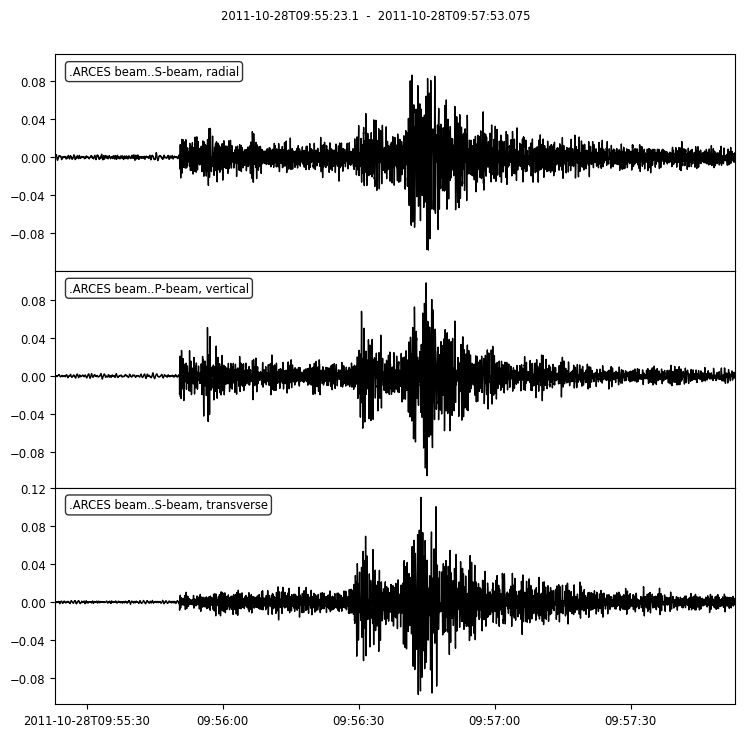

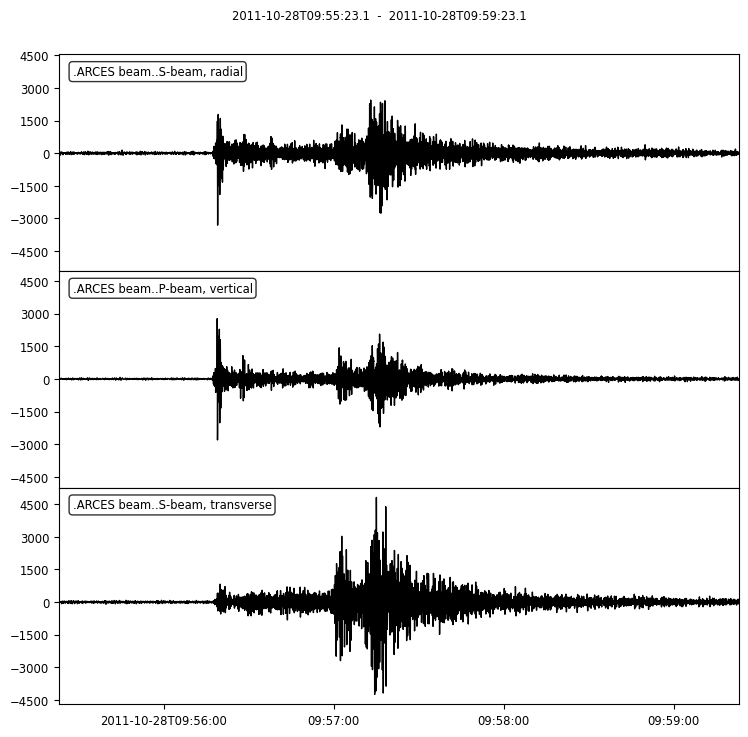

{   'analyst_pick_time': None,
    'az_to_arces': 305.73578325569537,
    'baz_to_arces': 117.87447329641759,
    'dist_to_arces': 404.8733583289168,
    'est_arrivaltime_arces': '2011-10-28 09:56:23.089000',
    'event_type': 'earthquake',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.007340566967080022,
    'magnitude_sqrtdist_ratio': 0.147702962144169,
    'magnitudes': [   {   'mag': 2.972,
                          'magnitude_type': 'Mb',
                          'origin_id': 'smi:local/baab84a4-dd4d-46ec-8602-3bc953512aa1',
                          'resource_id': 'smi:local/d5a19fae-9ea2-4a34-953c-f591ce8a92fe'},
                      {   'mag': 2.61,
                          'magnitude_type': 'Ml',
                          'origin_id': 'smi:local/baab84a4-dd4d-46ec-8602-3bc953512aa1',
                          'resource_id': 'smi:local/2ca78850-eb9d-4cb6-b7ac-09205c2b7d10'}],
    'origins': [   {   'arrivals': [   {   'azimuth': 25.291736,
              

In [12]:
index = true_positive_indexes[i]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
i += 1

# False Positives

In [13]:
j = 0

Predicted label: [ 0.8307155], Correct: [0]
Transformed
0


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


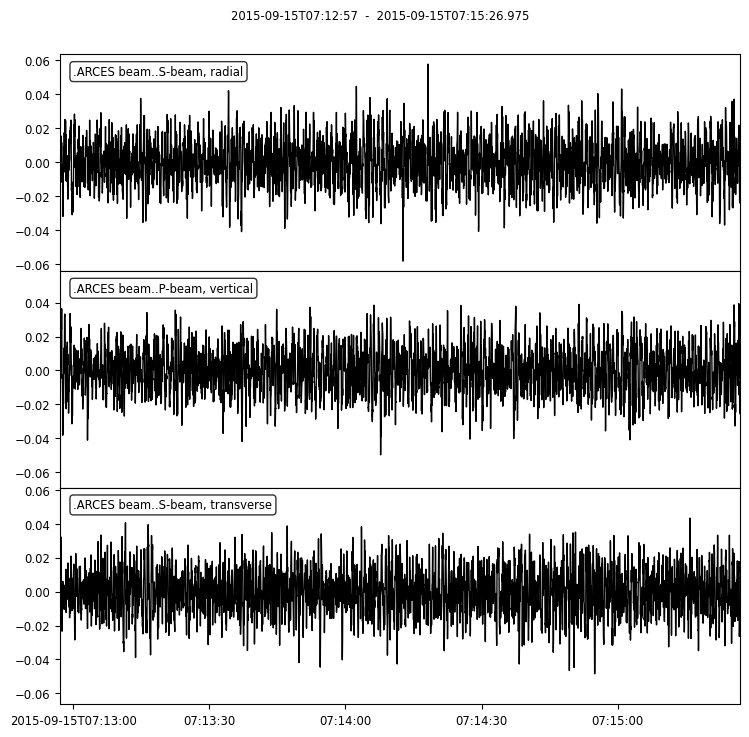

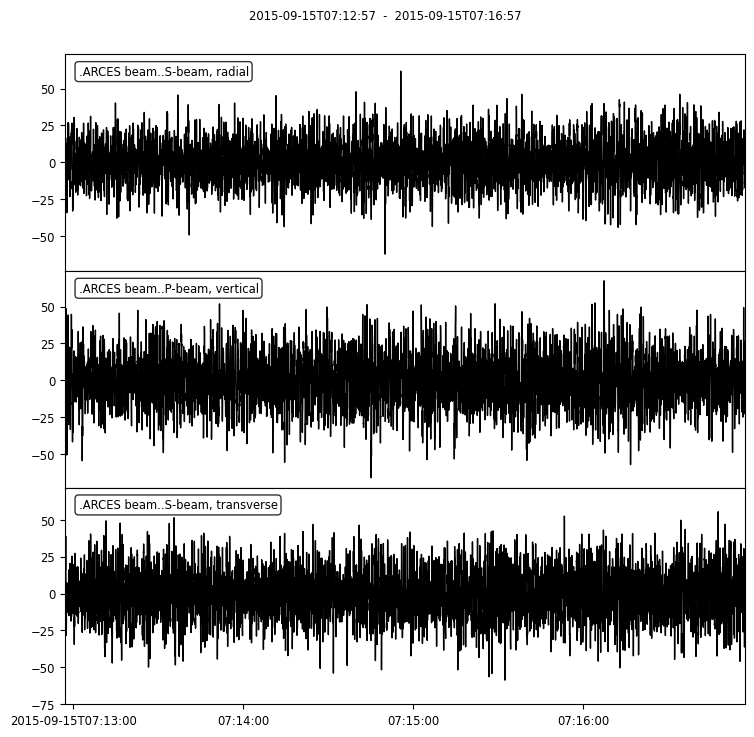

{   'analyst_pick_time': None,
    'baz_to_arces': 3.871113707856728,
    'est_arrivaltime_arces': '2015-09-15 07:13:57',
    'trace_stats': {   'channels': [   'P-beam, vertical',
                                       'S-beam, transverse',
                                       'S-beam, radial'],
                       'sampling_rate': 40.0,
                       'starttime': '2015-09-15T07:12:57.000000Z',
                       'station': 'ARCES beam'}}


In [14]:
# Plotting false negative
index = false_positives_indexes[j]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
print(j)
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
j += 1

# True Negatives

In [15]:
k = 0

Predicted label: [ 0.00171719], Correct: [0]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


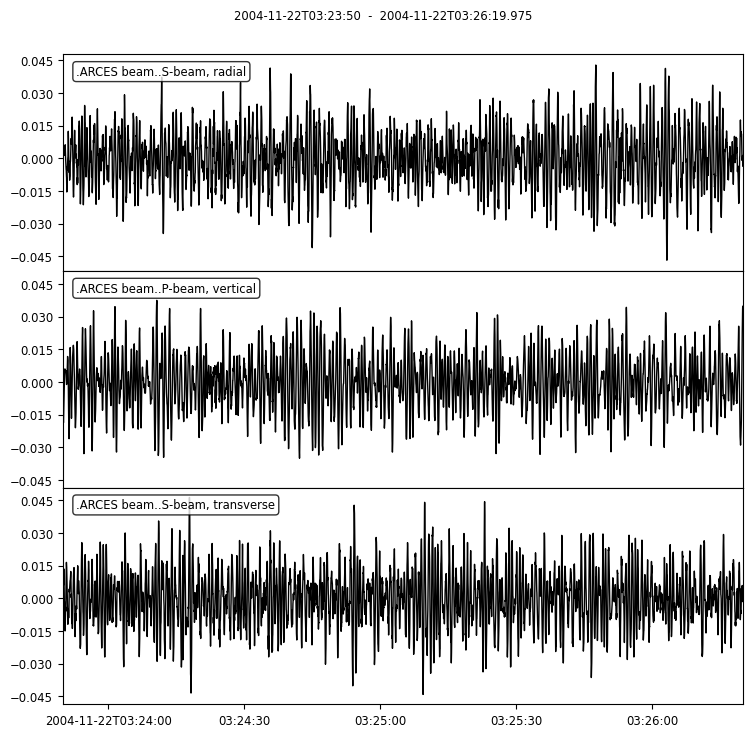

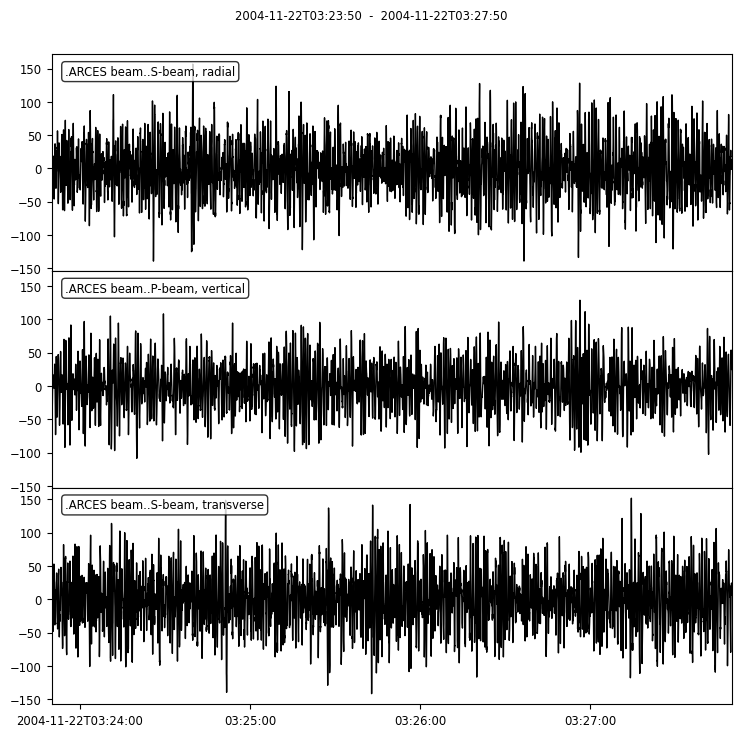

{   'analyst_pick_time': None,
    'baz_to_arces': 6.206188843804857,
    'est_arrivaltime_arces': '2004-11-22 03:24:50',
    'trace_stats': {   'channels': [   'P-beam, vertical',
                                       'S-beam, transverse',
                                       'S-beam, radial'],
                       'sampling_rate': 40.0,
                       'starttime': '2004-11-22T03:23:50.000000Z',
                       'station': 'ARCES beam'}}


In [16]:
# Plotting false negative
index = true_negative_indexes[k]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
k += 1

# False Negatives

In [17]:
m = 0

Predicted label: [ 0.25925747], Correct: [1]
Transformed
0


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


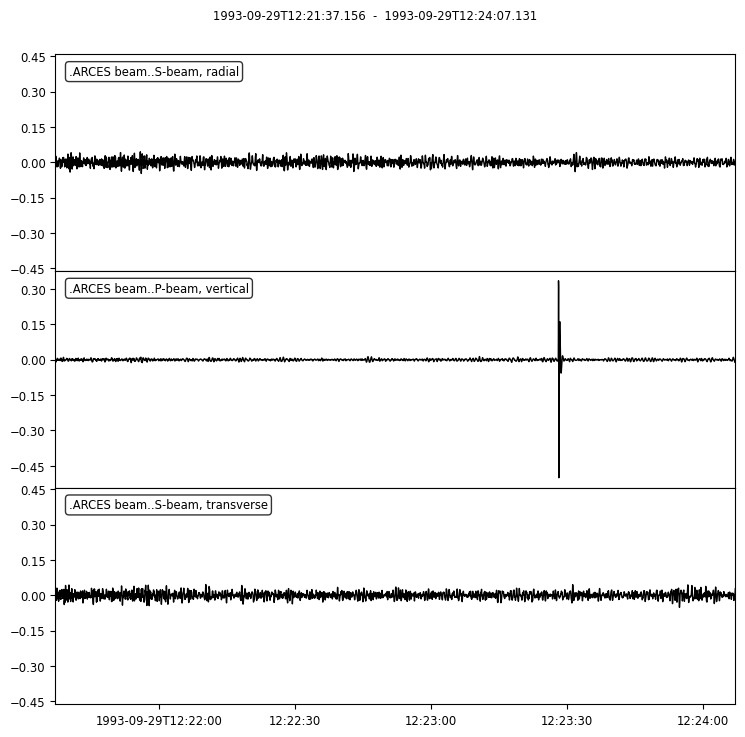

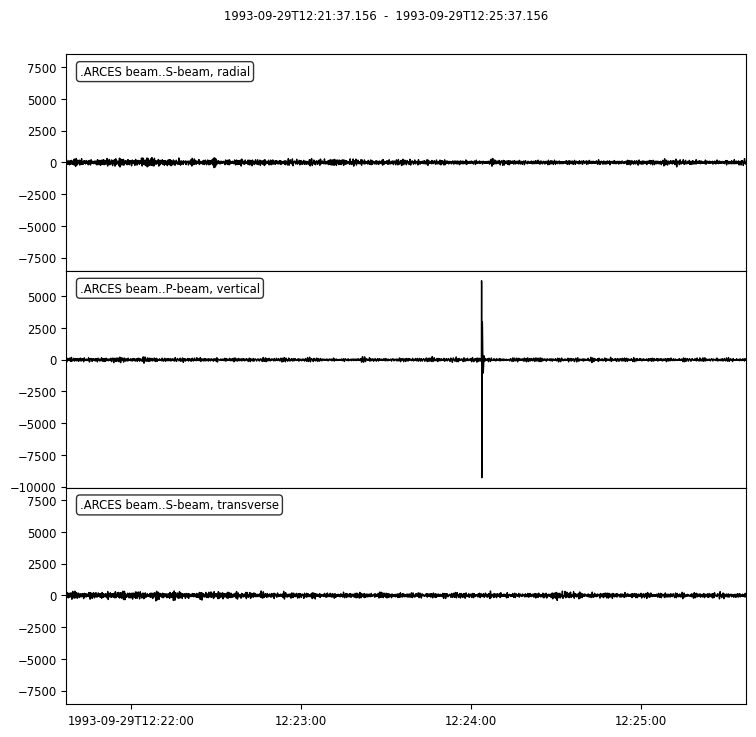

{   'analyst_pick_time': None,
    'az_to_arces': 8.64312250267359,
    'baz_to_arces': 191.78463533819962,
    'dist_to_arces': 896.6907013593263,
    'est_arrivaltime_arces': '1993-09-29 12:22:37.152000',
    'event_type': 'explosion',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.0020073811374103846,
    'magnitude_sqrtdist_ratio': 0.06011061509699175,
    'magnitudes': [   {   'creation_info': {'agency_id': 'HEL'},
                          'mag': 1.8,
                          'mag_errors': {'uncertainty': 0.3},
                          'magnitude_type': 'MA',
                          'origin_id': 'smi:local/90b0382f-98d9-4165-8014-4d0ff15a04ae',
                          'resource_id': 'smi:local/913eed6d-a4ff-4a1f-a452-1d6165980a45',
                          'station_count': 6}],
    'origins': [   {   'creation_info': {'agency_id': 'HEL'},
                       'depth': 0.0,
                       'latitude': 61.612,
                       'latitude_err

In [18]:
# Plotting false negative
index = false_negatives_indexes[m]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
print(m)
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
m += 1